In [7]:
import cv2,os
import numpy as np
from matplotlib import pyplot as plt
import torch
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from tqdm import tqdm
from torch.nn import functional as F
from collections import OrderedDict
import math

# 0. Load Model and Data

In [2]:
Data_00=np.load("results2022/01x40_padded.npy",allow_pickle=True)
Data_01Nami=np.load("results2022/02x40_padded.npy",allow_pickle=True)

print("Data_00.shape:", Data_00.shape)
print("Data_01Nami.shape:", Data_01Nami.shape)

Data_00.shape: (65969, 100, 100, 3)
Data_01Nami.shape: (3219, 100, 100, 3)


# 1. GradCAM
* this code is used by: https://github.com/jacobgil/pytorch-grad-cam
* Example: https://colab.research.google.com/drive/1UKcvOL_5sdDPJKU69MiADp8Y1-e24vz9?usp=sharing#scrollTo=AlrrU_yW9ZCX

In [69]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.guided_backprop import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,deprocess_image,preprocess_image
from torchvision.models import resnet50

def predict(model,input_tensor,true_y):
    model.eval()
    output = model(input_tensor)
    pre_y = output.argmax(1).cpu().item()
    return pre_y==true_y, pre_y

def gradcams(model,input_tensor,target_layers,imgpad,optioncam):
    # GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
    if optioncam=="GradCAM":
        cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="ScoreCAM":
        cam = ScoreCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="GradCAMPlusPlus":
        cam = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="AblationCAM":
        cam = AblationCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="XGradCAM":
        cam = XGradCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="EigenCAM":
        cam = EigenCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="FullGrad":
        cam = FullGrad(model=model, target_layers=target_layers, use_cuda=True)
    else:
        return print("your option is not support")
    # Note: input_tensor can be a batch tensor with several images!
    # If None, returns the map for the highest scoring category. 
    # Otherwise, targets the requested index. target_index = 1
    targets = None
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
#     grayscale_cam = cam(input_tensor=input_tensor, targets=targets,aug_smooth=True,eigen_smooth=True)
    grayscale_cam = cam(input_tensor, targets)[0]
    # In this example grayscale_cam has only one image in the batch:
    visualization = show_cam_on_image(imgpad, grayscale_cam, use_rgb=False)
    
    # Guided-GradCAM
    gb_model = GuidedBackpropReLUModel(model=model, use_cuda=True)
    gb = gb_model(input_tensor, targets)
    gb = np.maximum(gb,0)*(1/np.amax(gb))
    cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
    cam_gb = cam_mask * gb
    
    return visualization,gb,cam_gb,cam_mask

In [98]:
# load model
device = "cuda"
model = torch.load("SelfResnet18_L2F1_200.pkl")
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 1.1 CAM results 

In [109]:
target_layers = [model.layer2]
# cam's option: GradCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, ScoreCAM, FullGrad
optioncam = "GradCAM"

In [110]:
# fig, ax = plt.subplots(5,5, figsize = (40,40))
# for n in range(25):
#     img = Data_01Nami[n]
#     img = np.float32(img)/255
#     img = img/(np.amax(img)*1.2)
#     plt.subplot(5,5,n+1)
#     plt.title("Image Num "+str(n))
#     plt.imshow(img)

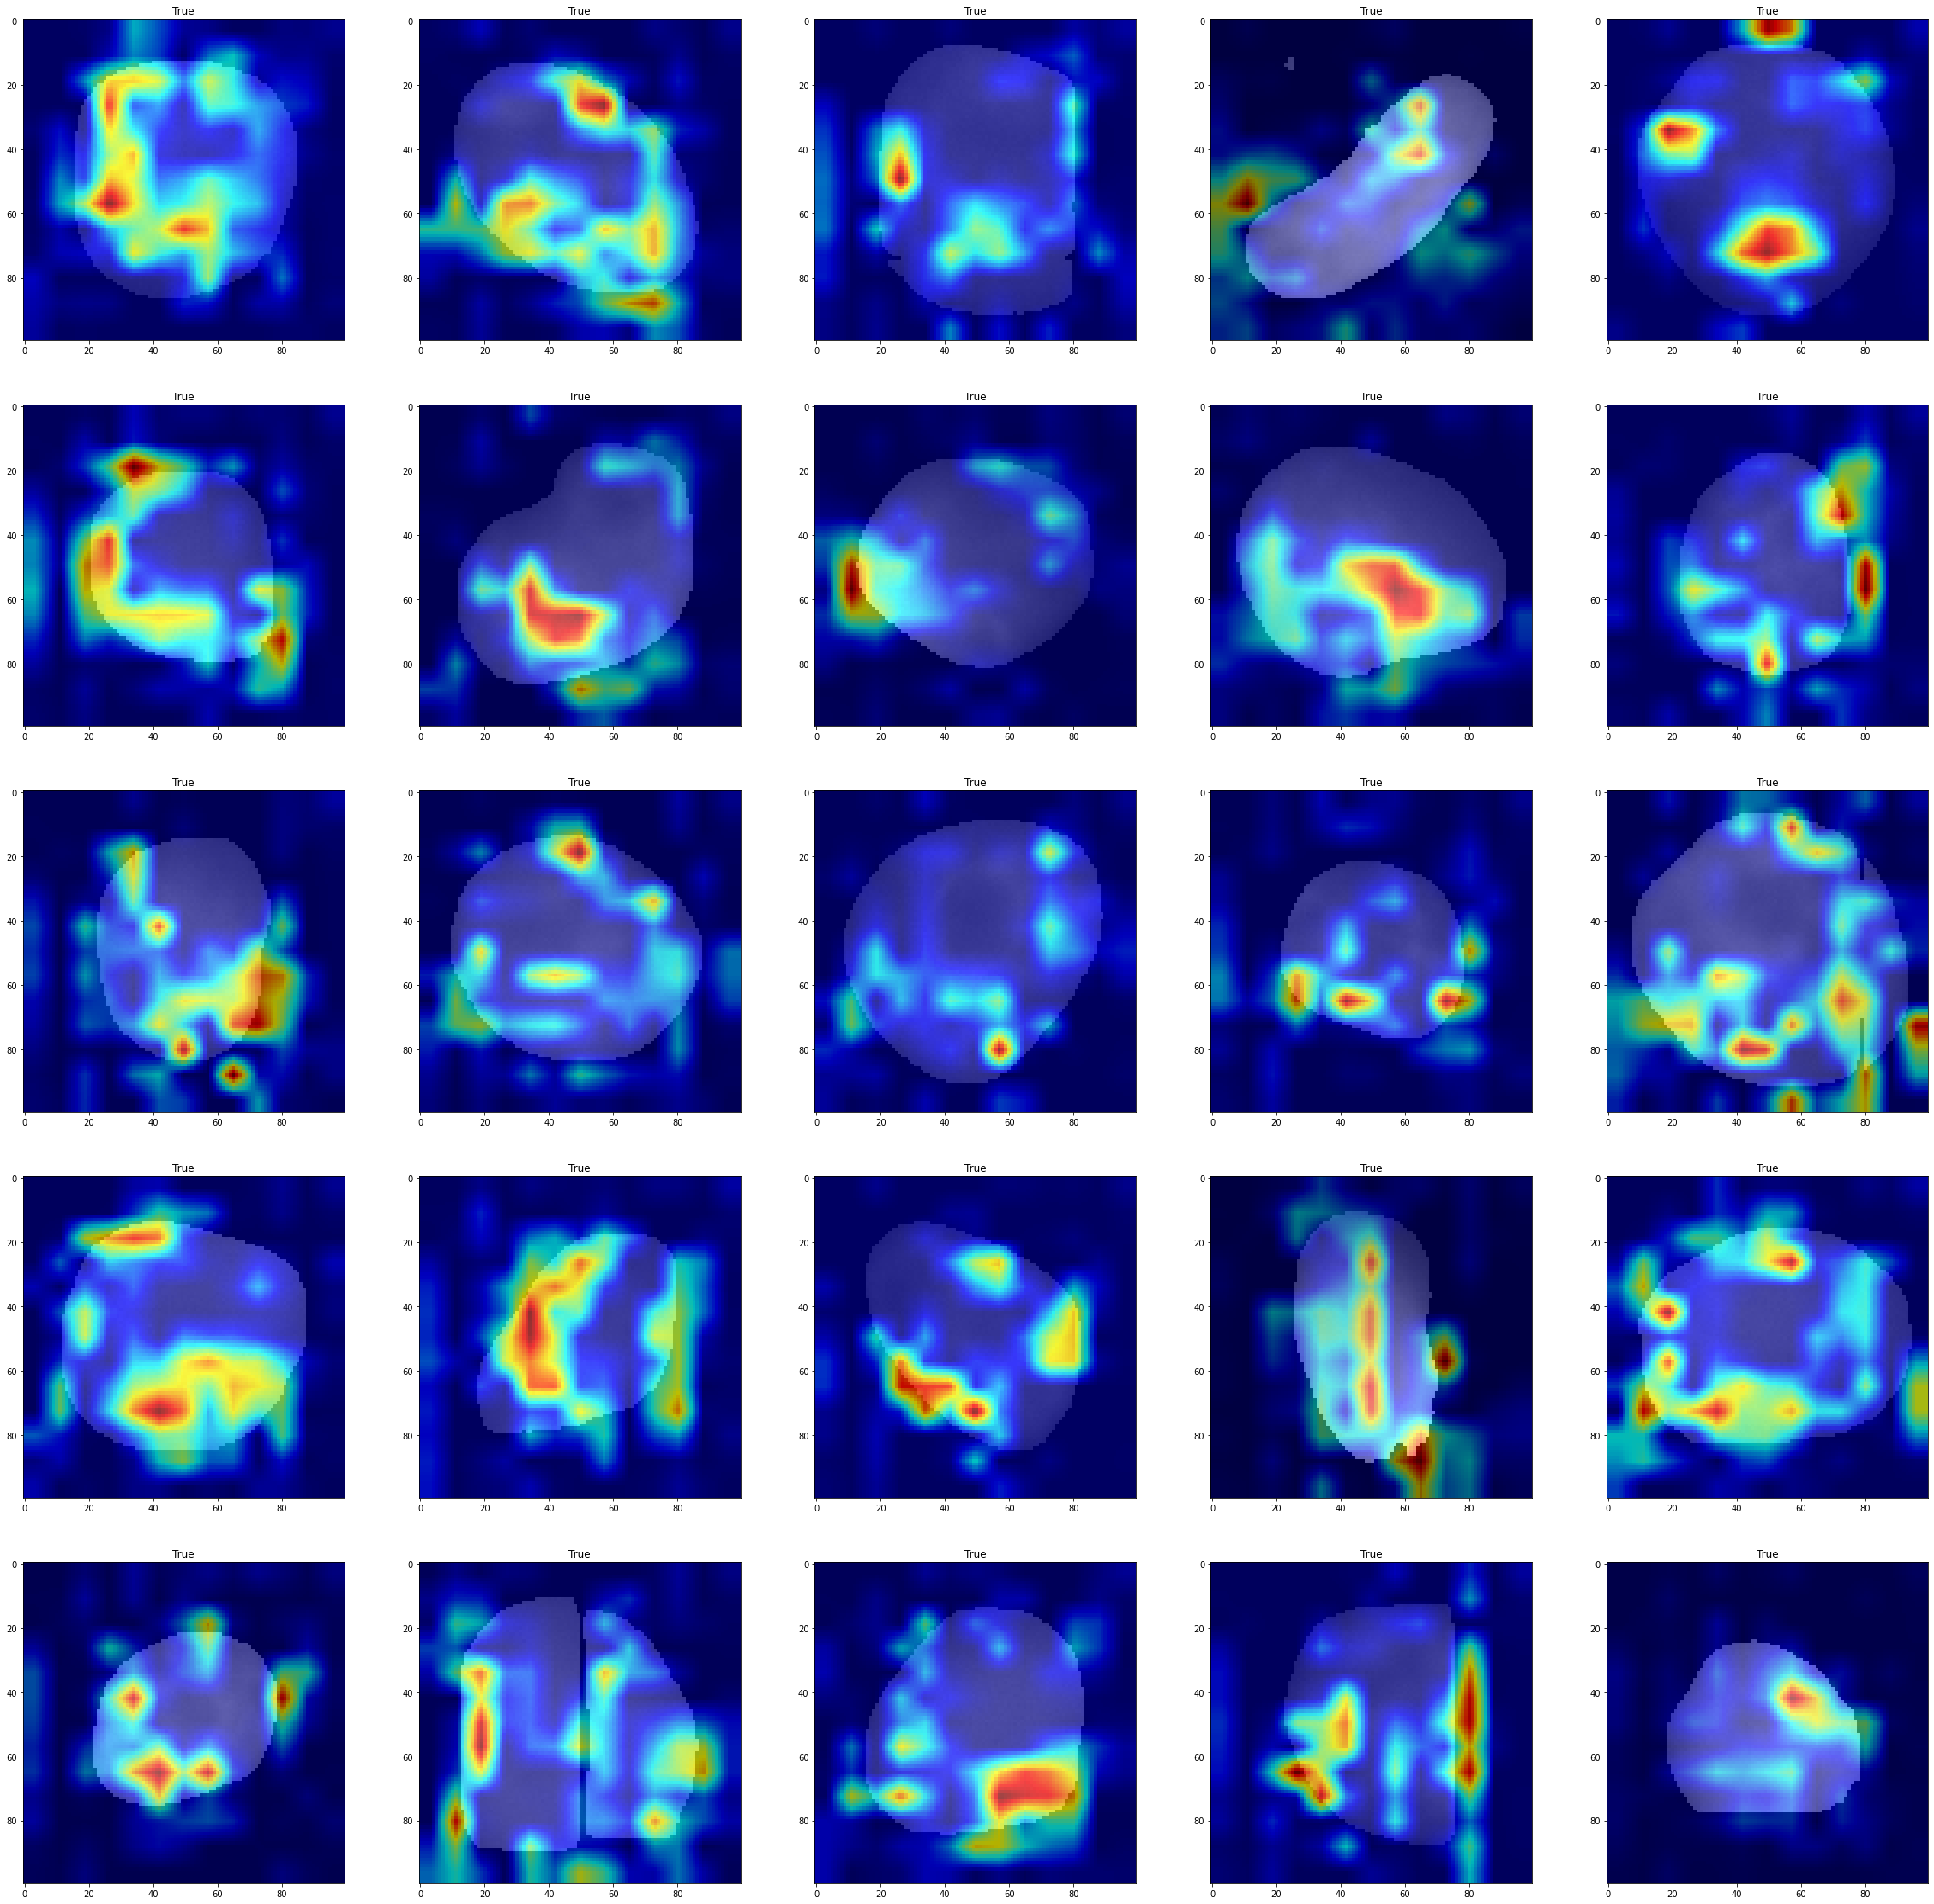

In [111]:
true_y = 0
fig, ax = plt.subplots(5,5, figsize = (40,40))
for n in range(25):
    img = Data_00[n]
    img = np.float32(img)/255

    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)

    tf,pred = predict(model,input_tensor,true_y)
    visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)

    plt.subplot(5,5,n+1)
    plt.title(tf)
    plt.imshow(cv2.cvtColor(visualization, cv2.COLOR_BGR2RGB))

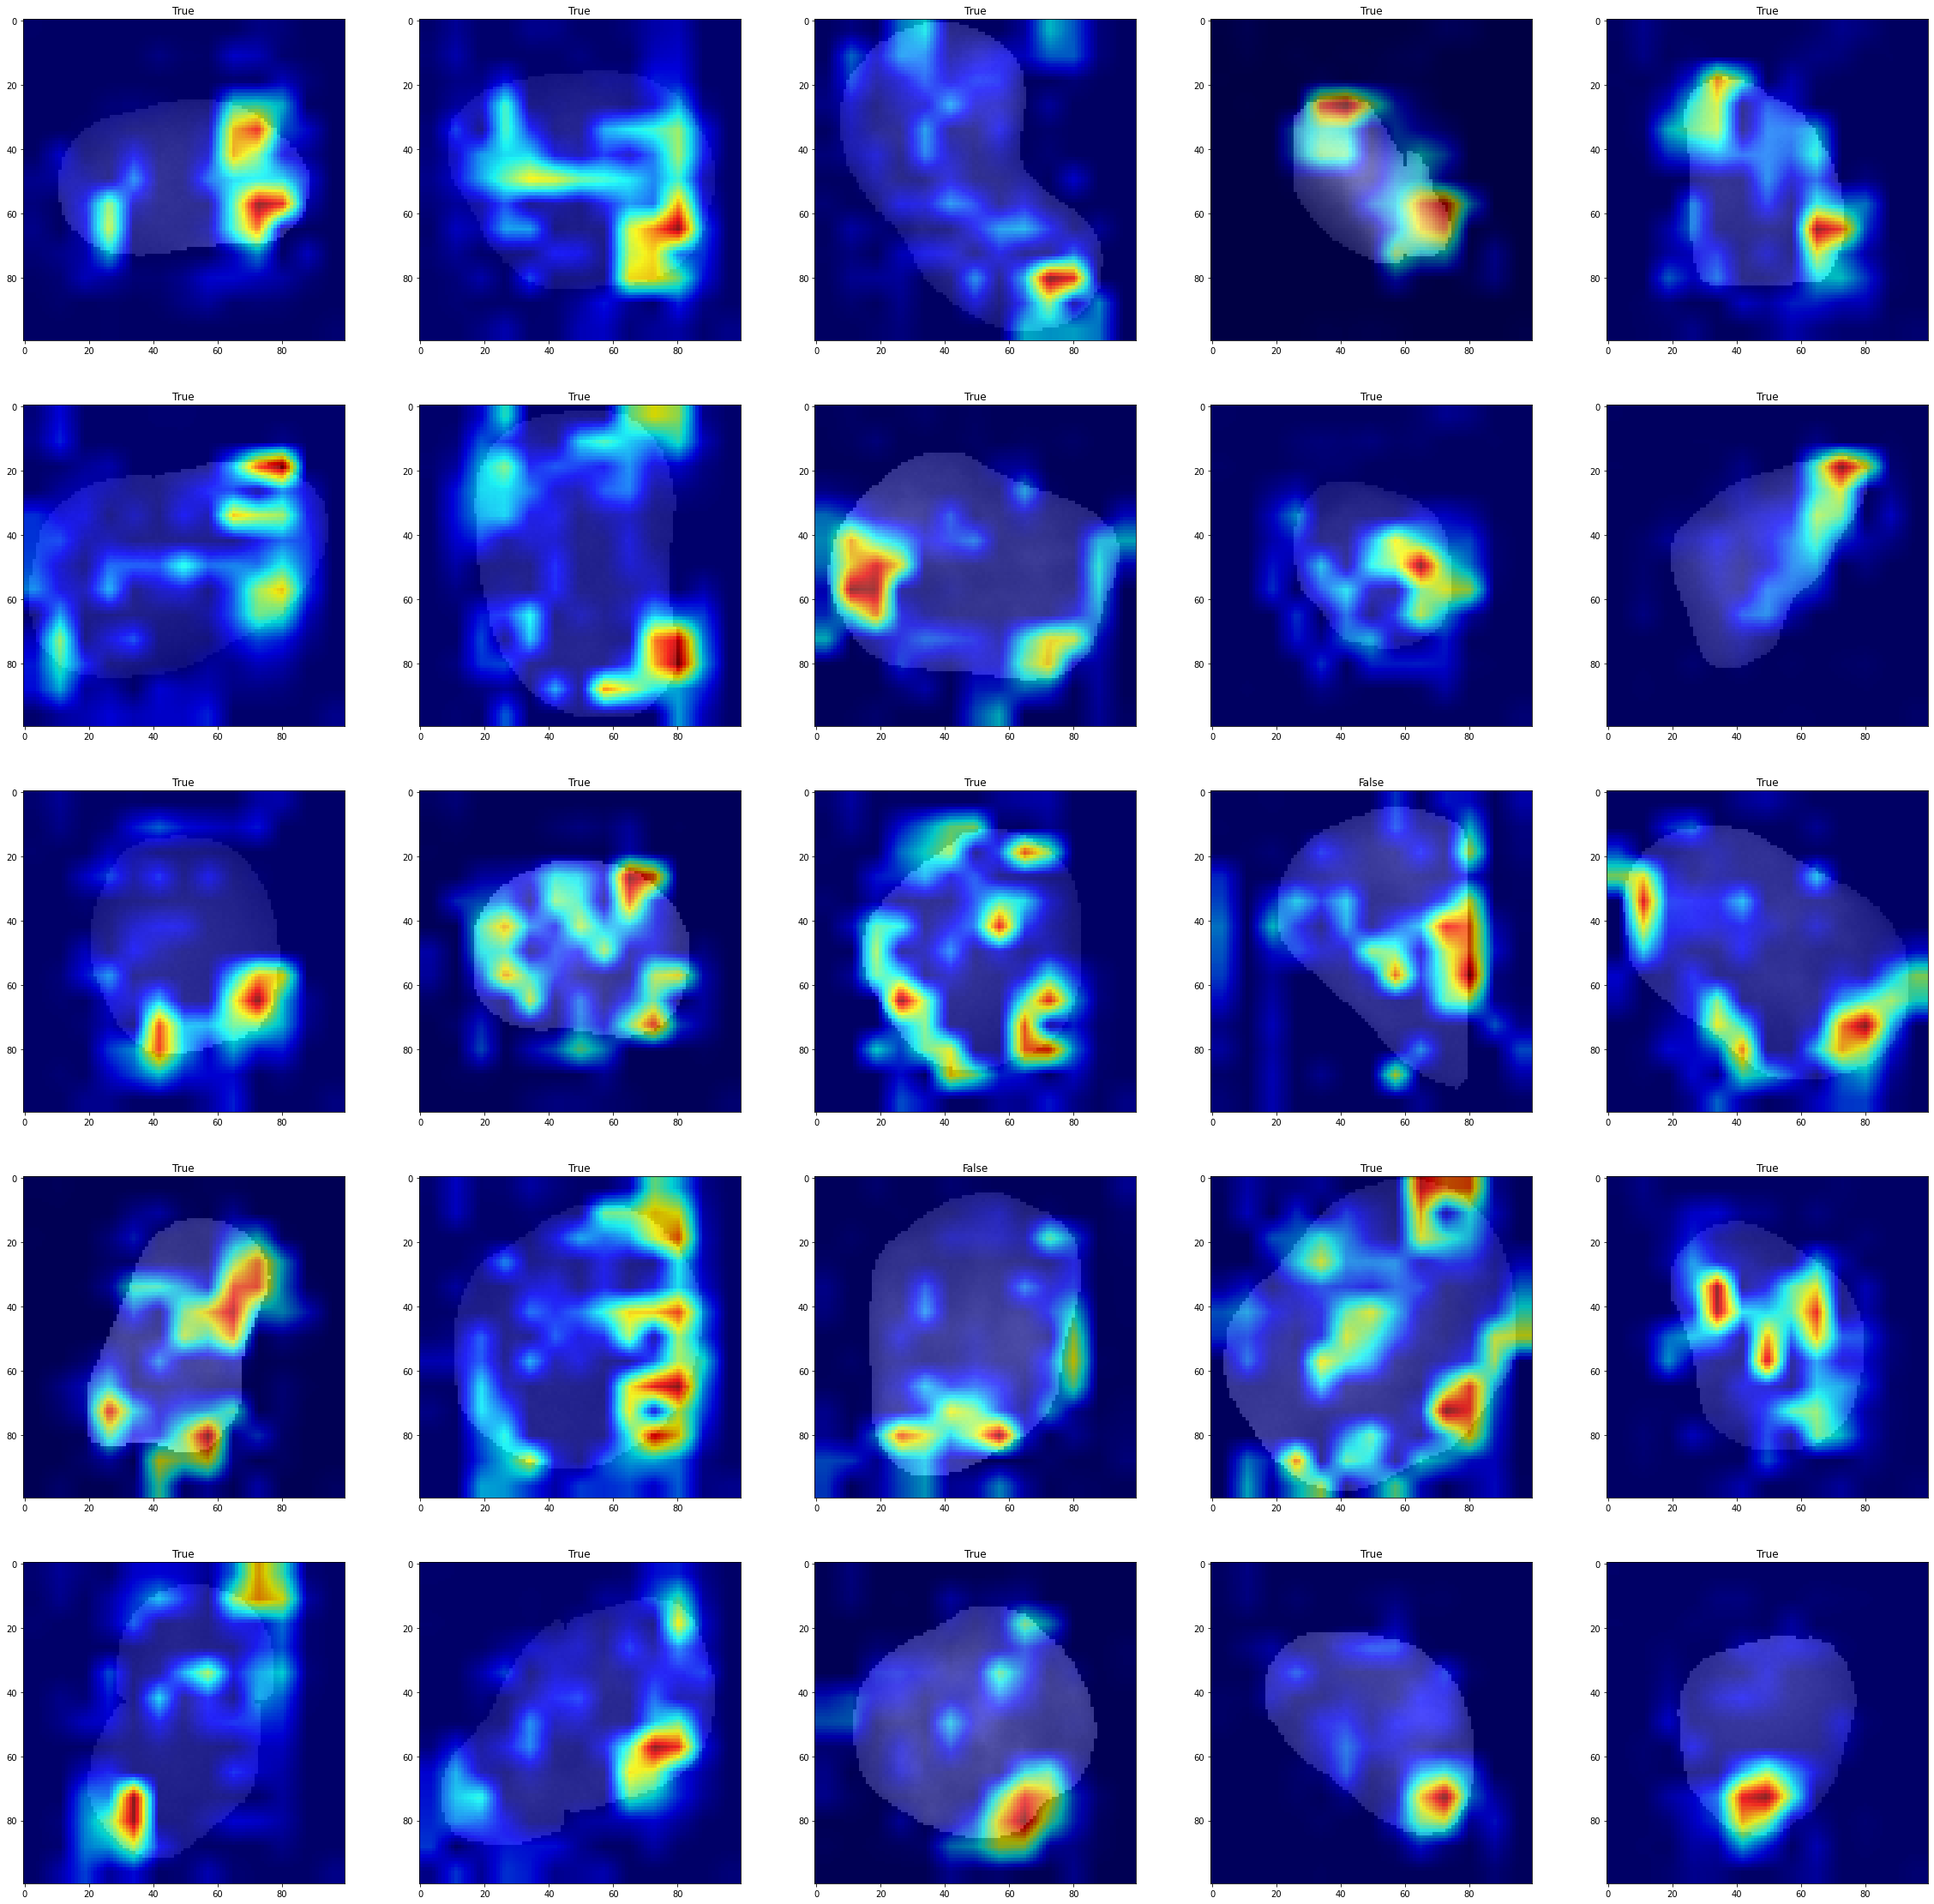

In [112]:
true_y = 1
fig, ax = plt.subplots(5,5, figsize = (40,40))
for n in range(25):
        img = Data_01Nami[n]
        img = np.float32(img)/255

        transform = transforms.Compose([transforms.ToTensor()])
        input_tensor = transform(img).unsqueeze(0).to(device)

        tf,pred = predict(model,input_tensor,true_y)
        visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
        
        plt.subplot(5,5,n+1)
        plt.title(tf)
        plt.imshow(cv2.cvtColor(visualization, cv2.COLOR_BGR2RGB))

# 2. Guided-GradCAM

In [113]:
# # load model
# model = torch.load("SelfResnet18_L2F1.pkl")
# target_layers = [model.layer2]
# cam's option: GradCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, ScoreCAM, FullGrad
# optioncam = "GradCAM"

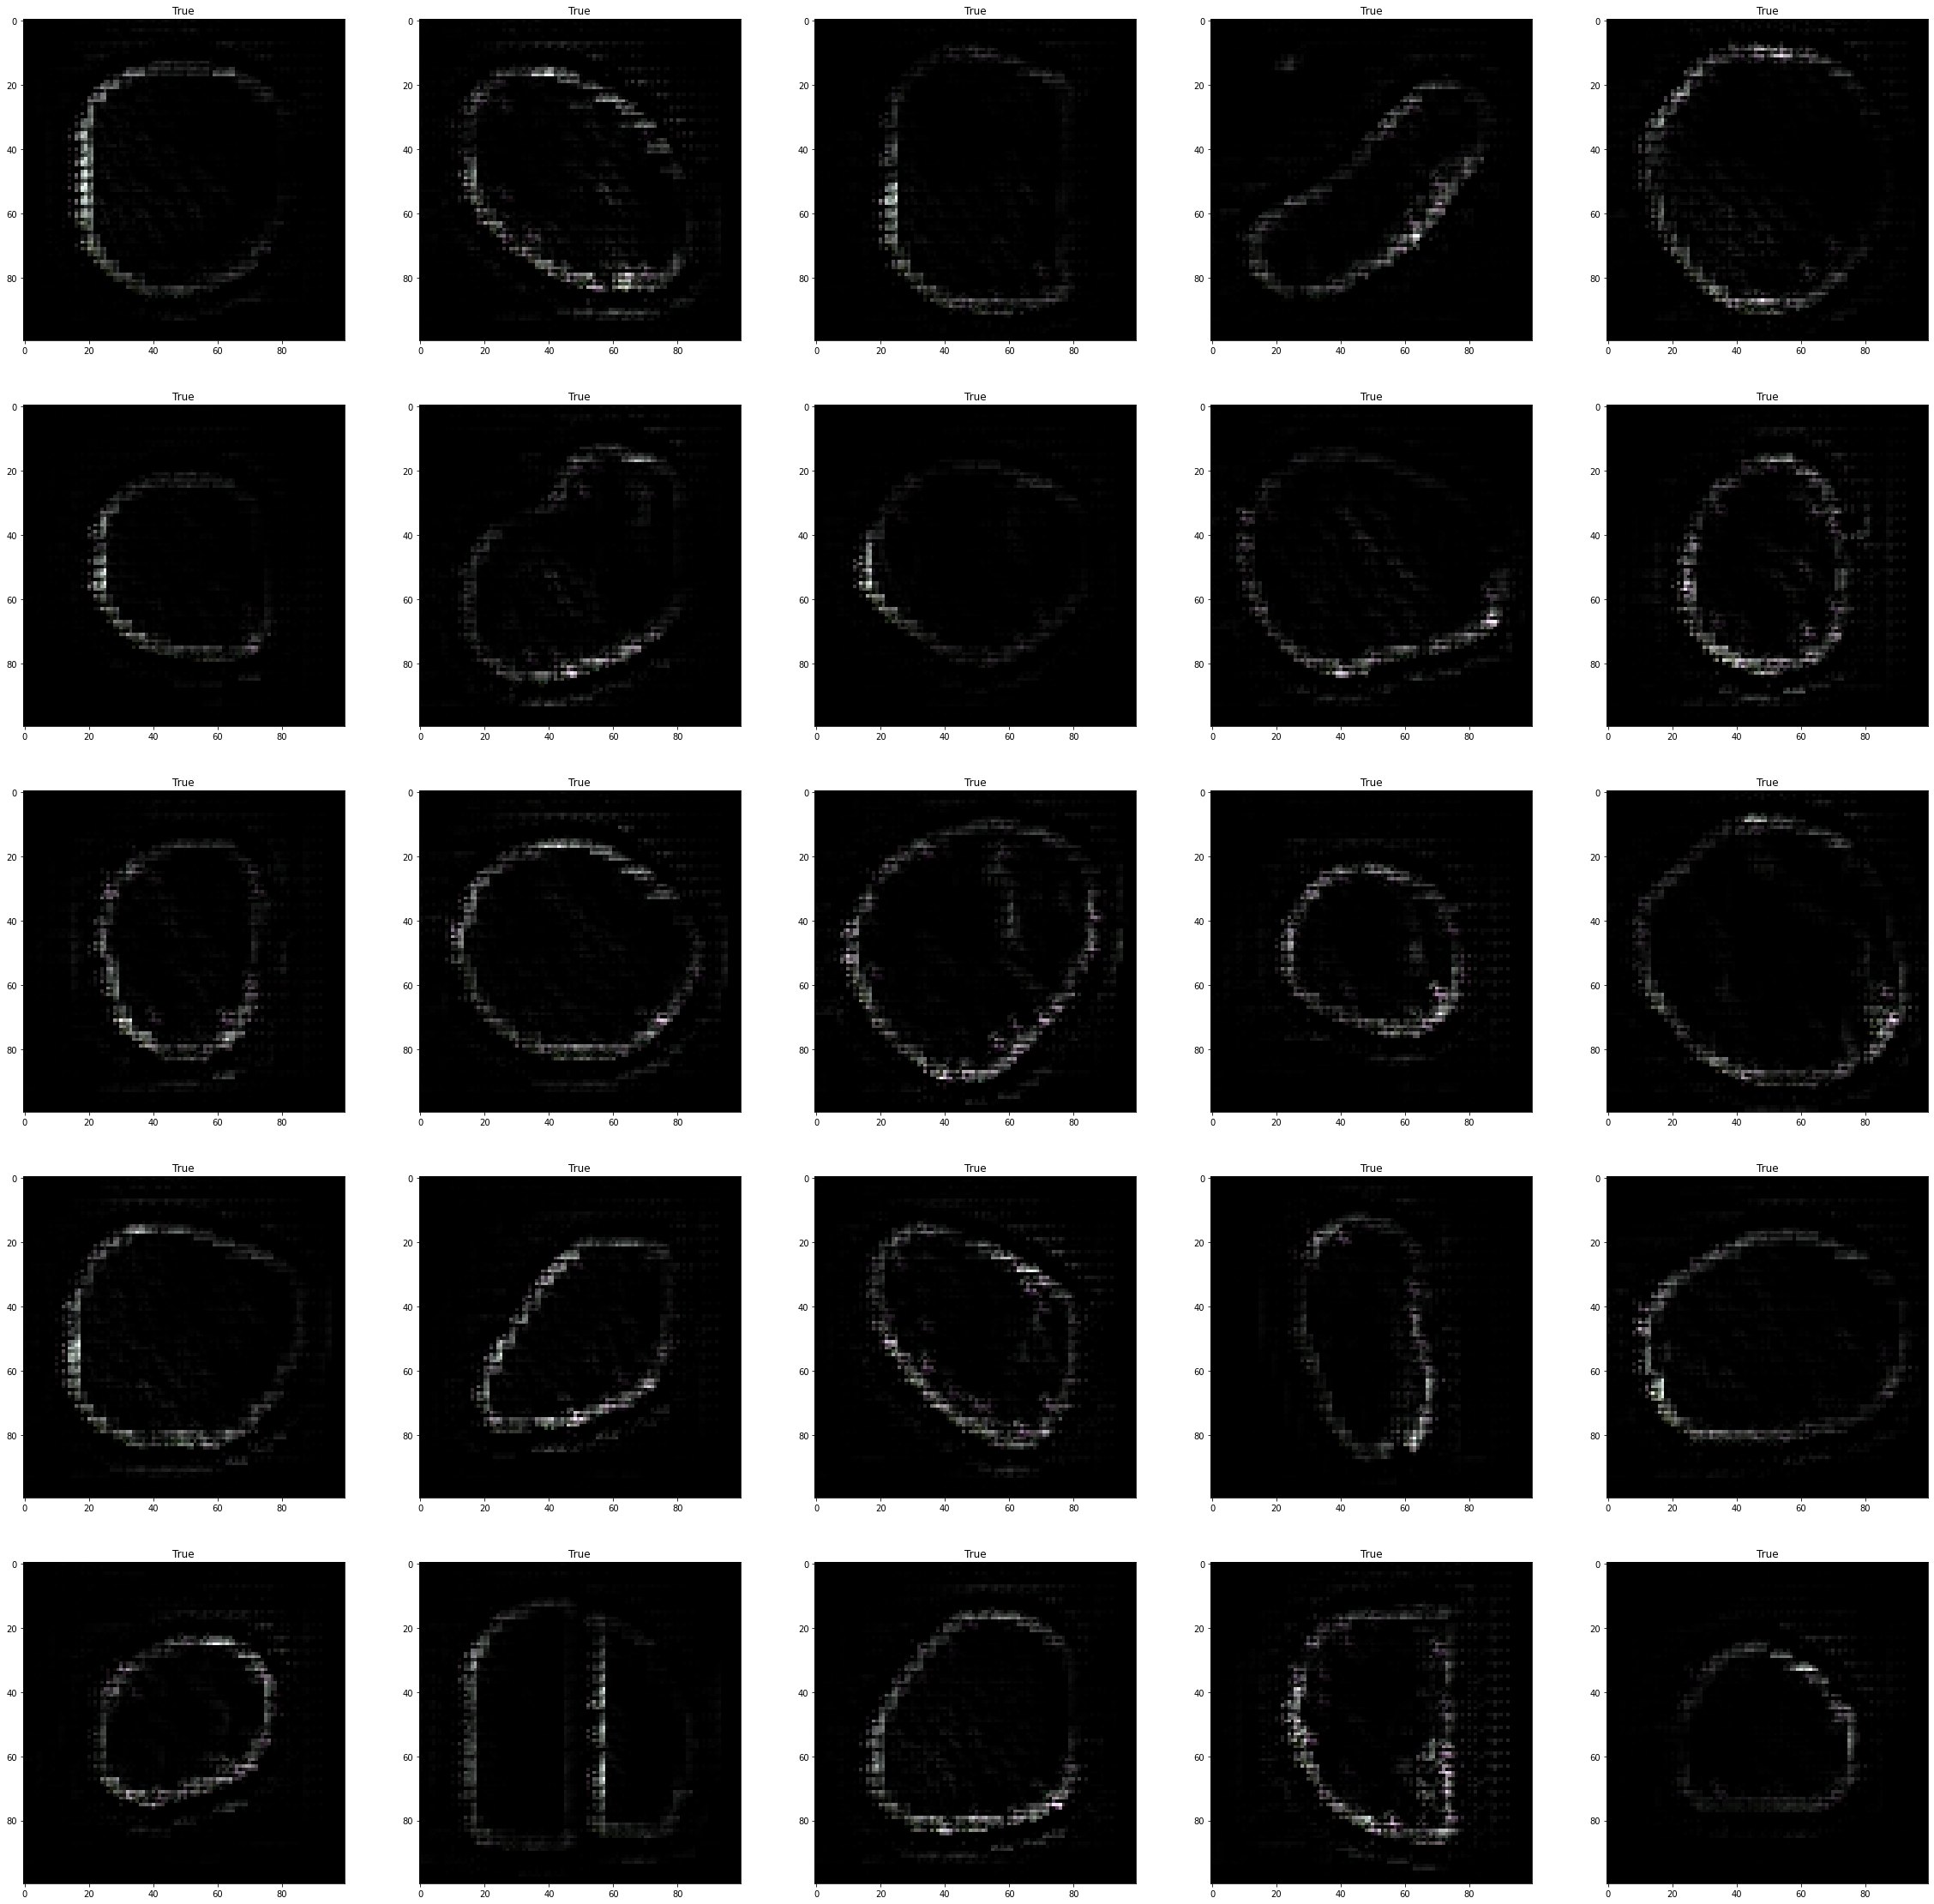

In [116]:
true_y = 0
fig, ax = plt.subplots(5,5, figsize = (40,40))
for n in range(25):
    img = Data_00[n]
    img = np.float32(img)/255

    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)

    tf,pred = predict(model,input_tensor,true_y)
    visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)

    plt.subplot(5,5,n+1)
    plt.title(tf)
    plt.imshow(cv2.cvtColor(gb, cv2.COLOR_BGR2RGB))

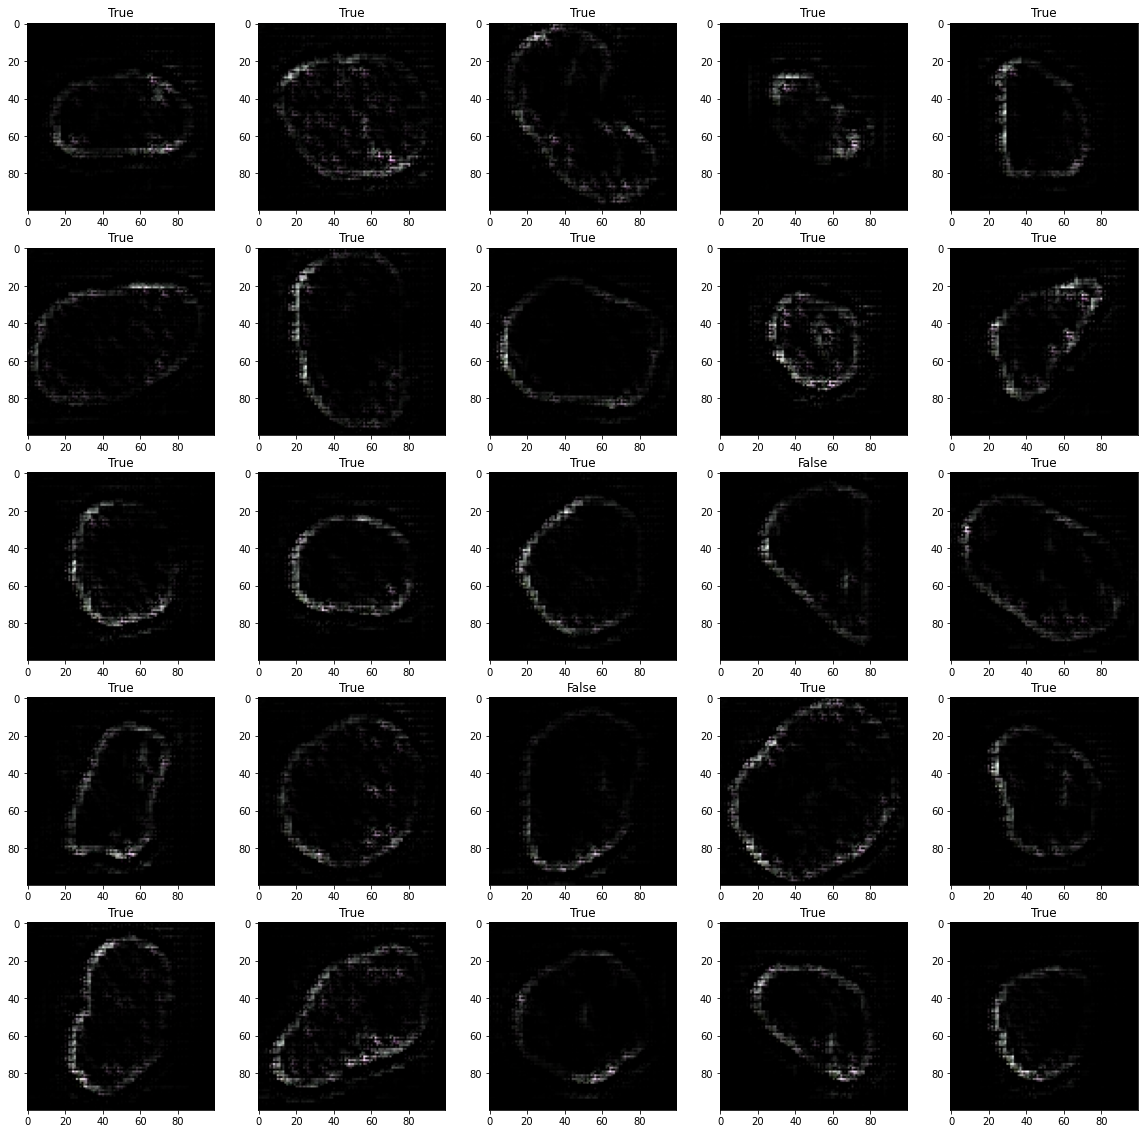

In [117]:
true_y = 1
fig, ax = plt.subplots(5,5, figsize = (20,20))
for n in range(25):
        img=Data_01Nami[n]
        img = np.float32(img)/255

        transform = transforms.Compose([transforms.ToTensor()])
        input_tensor = transform(img).unsqueeze(0).to(device)

        tf,pred = predict(model,input_tensor,true_y)
        visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
        
        plt.subplot(5,5,n+1)
        plt.title(tf)
        plt.imshow(cv2.cvtColor(gb, cv2.COLOR_BGR2RGB))

# 3. Discussion

# intensity of all gradcam heatmap

In [137]:
true_y = 0
count = 0
intensity00_conv1 = np.zeros((100,100))
intensity00_layer1 = np.zeros((100,100))
intensity00_layer2 = np.zeros((100,100))
intensity00_gb = np.zeros((100,100))
total = 100

for n in tqdm(range(total)):
    img = Data_00[n]
    img = np.float32(img)/255

    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)
    
    tf,pred = predict(model,input_tensor,true_y)
    if tf == True:
        visualization,gb,cam_gb,cam = gradcams(model,input_tensor,[model.conv1],img,optioncam)
        intensity00_conv1+=cam[:,:,0]
        visualization,gb,cam_gb,cam = gradcams(model,input_tensor,[model.layer1],img,optioncam)
        intensity00_layer1+=cam[:,:,0]
        visualization,gb,cam_gb,cam = gradcams(model,input_tensor,[model.layer2],img,optioncam)
        intensity00_layer2+=cam[:,:,0]
        intensity00_gb+=gb[:,:,0]
        count+=1
print("Data00 acc: {:.3f}, count: {:}, total: {:} " .format(count/total,count,total))

100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.39it/s]

Data00 acc: 1.000, count: 100, total: 100 


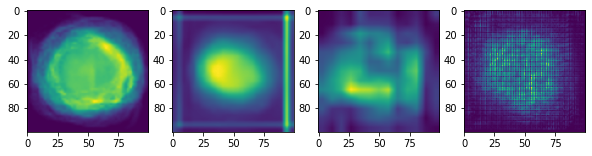

In [138]:
intensity00_conv1 = intensity00_conv1/count
intensity00_conv1 = intensity00_conv1/np.amax(intensity00_conv1)

intensity00_layer1 = intensity00_layer1/count
intensity00_layer1 = intensity00_layer1/np.amax(intensity00_layer1)

intensity00_layer2 = intensity00_layer2/count
intensity00_layer2 = intensity00_layer2/np.amax(intensity00_layer2)

intensity00_gb = intensity00_gb/count
intensity00_gb = intensity00_gb/np.amax(intensity00_gb)
plt.figure(figsize=(10,10))
plt.subplot(1,4,1)
plt.imshow(intensity00_conv1)
plt.subplot(1,4,2)
plt.imshow(intensity00_layer1)
plt.subplot(1,4,3)
plt.imshow(intensity00_layer2)
plt.subplot(1,4,4)
plt.imshow(intensity00_gb)

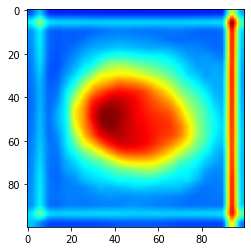

In [143]:
heatmap = cv2.cvtColor(cv2.applyColorMap(np.uint8(255 * intensity00_layer1), cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB)
plt.imshow(heatmap)

In [121]:
true_y = 1
count = 0
intensity01_conv1 = np.zeros((100,100))
intensity01_layer1 = np.zeros((100,100))
intensity01_layer2 = np.zeros((100,100))
intensity01_gb = np.zeros((100,100))
total = len(Data_01Nami)

for n in tqdm(range(total)):
    img = Data_01Nami[n]
    img = np.float32(img)/255

    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)
    
    tf,pred = predict(model,input_tensor,true_y)
    if tf == True:
        visualization,gb,cam_gb,cam = gradcams(model,input_tensor,[model.conv1],img,optioncam)
        intensity01_conv1+=cam[:,:,0]
        visualization,gb,cam_gb,cam = gradcams(model,input_tensor,[model.layer1],img,optioncam)
        intensity01_layer1+=cam[:,:,0]
        visualization,gb,cam_gb,cam = gradcams(model,input_tensor,[model.layer2],img,optioncam)
        intensity01_layer2+=cam[:,:,0]
        intensity01_gb+=gb[:,:,0]
        count+=1
print("Data00 acc: {:.3f}, count: {:}, total: {:} " .format(count/total,count,total))

100%|██████████████████████████████████████████████████████████████████████████████████| 3219/3219 [02:01<00:00, 26.43it/s]

Data00 acc: 0.954, count: 3070, total: 3219 


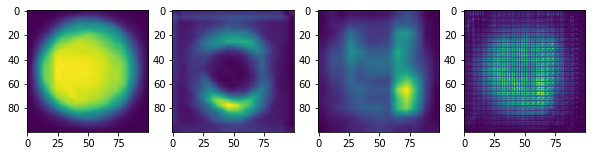

In [122]:
intensity01_conv1 = intensity01_conv1/(count*np.amax(intensity01_conv1))
intensity01_layer1 = intensity01_layer1/(count*np.amax(intensity01_layer1))
intensity01_layer2 = intensity01_layer2/(count*np.amax(intensity01_layer2))
intensity01_gb = intensity01_gb/(count*np.amax(intensity00_gb))
plt.figure(figsize=(10,10))
plt.subplot(1,4,1)
plt.imshow(intensity01_conv1)
plt.subplot(1,4,2)
plt.imshow(intensity01_layer1)
plt.subplot(1,4,3)
plt.imshow(intensity01_layer2)
plt.subplot(1,4,4)
plt.imshow(intensity01_gb)

## 3.1 Use CAM mask results as input image, predict by the same CNN

In [33]:
img = Data_00[1]
transform = transforms.Compose([transforms.ToTensor()])
input_tensor = transform(img).unsqueeze(0).to(device)
tf,pred = predict(model,input_tensor,true_y)

img = np.float32(img)/255
visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)

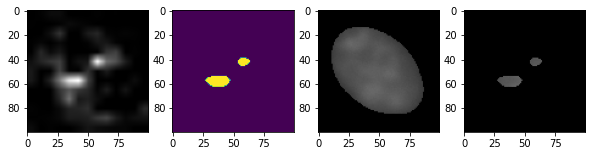

In [34]:
plt.figure(figsize=(10,10))
plt.subplot(1,4,1)
plt.imshow(cam)
mask = transform(cam)[0].ge(0.5).numpy()
plt.subplot(1,4,2)
plt.imshow(mask)
plt.subplot(1,4,3)
plt.imshow(img)
camcell = np.multiply(mask,img[:,:,0])
camcell = cv2.merge([camcell,camcell,camcell])
plt.subplot(1,4,4)
plt.imshow(camcell)

In [32]:
total = 1000
count = 0
true_y = 0
thre = 0.5
# fig, ax = plt.subplots(5,5, figsize = (40,40))
for n in tqdm(range(total)):
    img = Data_00[n]
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)

    tf,pred = predict(model,input_tensor,true_y)
    img = np.float32(img)/255
    visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
    if tf == True:
        mask = transform(cam)[0].ge(thre).numpy()
        camcell = np.multiply(mask,img[:,:,0])
        camcell = cv2.merge([camcell,camcell,camcell])
        input_tensor = transform(camcell).unsqueeze(0).to(device)
        tf,pred = predict(model,input_tensor,true_y)
        if tf == True:
            count+=1
print("cam mask cell_00 accuracy is ", count/total)

100%|██████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 65.11it/s]

cam mask cell_00 accuracy is  0.176


In [90]:
total = 1000
count = 0
true_y = 1
thre = 0.5
# fig, ax = plt.subplots(5,5, figsize = (40,40))
for n in tqdm(range(total)):
    img = Data_01Nami[n]
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)

    tf,pred = predict(model,input_tensor,true_y)
    img = np.float32(img)/255
    visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
    if tf == True:
        mask = transform(cam)[0].ge(thre).numpy()
        camcell = np.multiply(mask,img[:,:,0])
        camcell = cv2.merge([camcell,camcell,camcell])
        input_tensor = transform(camcell).unsqueeze(0).to(device)
        tf,pred = predict(model,input_tensor,true_y)
        if tf == True:
            count+=1
print("cam mask cell_01Nami accuracy is ", count/total)

100%|████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 63.25it/s]

cam mask cell_01Nami accuracy is  0.962


## 3.2 Use gb results as input image, predict by the same CNN

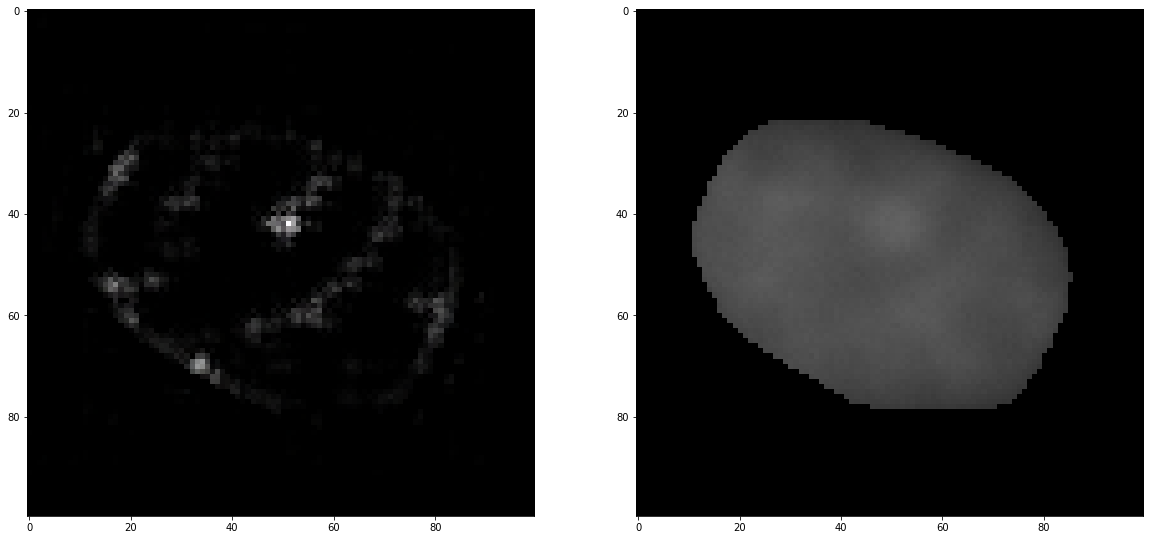

In [65]:
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(gb)
plt.subplot(1,2,2)
plt.imshow(img)

In [51]:
total = 1000
count = 0
true_y = 0
# fig, ax = plt.subplots(5,5, figsize = (40,40))
for n in tqdm(range(total)):
    img = Data_00[n]
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)

    tf,pred = predict(model,input_tensor,true_y)
    img = np.float32(img)/255
    visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
    if tf == True:
        input_tensor = transform(gb).unsqueeze(0).to(device)
        tf_gb,pred_gb = predict(model,input_tensor,true_y)
        if tf_gb == True:
            count+=1
print("gb accuracy is ", count/total)

100%|████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 62.03it/s]

gb accuracy is  0.203


In [50]:
total = 1000
count = 0
true_y = 1
# fig, ax = plt.subplots(5,5, figsize = (40,40))
for n in tqdm(range(total)):
    img = Data_01Nami[n]
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)

    tf,pred = predict(model,input_tensor,true_y)
    img = np.float32(img)/255
    visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
    if tf == True:
        input_tensor = transform(gb).unsqueeze(0).to(device)
        tf_gb,pred_gb = predict(model,input_tensor,true_y)
        if tf_gb == True:
            count+=1
print("gb accuracy is ", count/total)

100%|████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:32<00:00, 62.10it/s]

gb accuracy is  0.8535


## 3.3 test CNN model by category

In [18]:
total = Data_00.shape[0]
count = 0
true_y = 0
# fig, ax = plt.subplots(5,5, figsize = (40,40))
for n in tqdm(range(total)):
    img = Data_00[n]
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)
    tf,pred = predict(model,input_tensor,true_y)
    if tf == True:
        count+=1
print("00 accuracy is ", count/total)
print("count/total is ", count,total)

100%|███████████████████████████████████████████████████████████████████████████████| 65969/65969 [01:38<00:00, 672.74it/s]

00 accuracy is  0.9844927162758266
count/total is  64946 65969


In [19]:
total = Data_01Nami.shape[0]
count = 0
true_y = 1
# fig, ax = plt.subplots(5,5, figsize = (40,40))
for n in tqdm(range(total)):
    img = Data_01Nami[n]
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)
    tf,pred = predict(model,input_tensor,true_y)
    if tf == True:
        count+=1
print("01 accuracy is ", count/total)
print("count/total is ", count,total)

100%|█████████████████████████████████████████████████████████████████████████████████| 3219/3219 [00:04<00:00, 680.00it/s]

01 accuracy is  0.9913016464740603
count/total is  3191 3219


# 99. debug

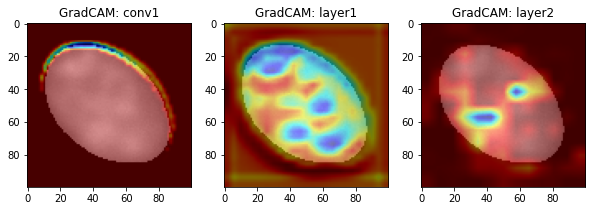

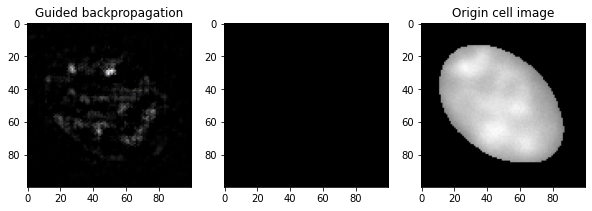

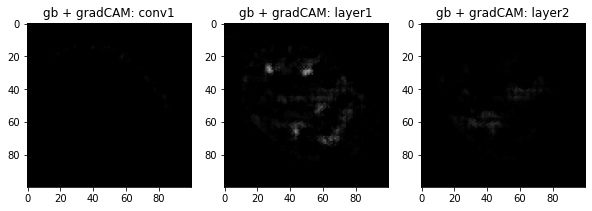

In [99]:
true_y = 0
img=Data_00[1]
img = np.float32(img)/255
transform = transforms.Compose([transforms.ToTensor()])
input_tensor = transform(img).unsqueeze(0).to("cuda")
tf,pred = predict(model,input_tensor,true_y)

img = img/np.amax(img)
gray = np.array([0.299,0.587,0.114])
layer = ["conv1","layer1","layer2"]

plt.figure(figsize=(10,10))
i=1
for target_layers in [[model.conv1],[model.layer1],[model.layer2]]:
    visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
    plt.subplot(1,3,i)
    plt.title("GradCAM: "+layer[i-1])
    plt.imshow(visualization)
    i+=1
    
plt.figure(figsize=(10,10))
i=1
for target_layers in [[model.conv1],[model.layer1],[model.layer2]]:
    visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
    plt.subplot(1,3,i)
    if i == 1:
        plt.title("Guided backpropagation")
        plt.imshow(gb)
    elif i == 3:
        plt.title("Origin cell image")
        plt.imshow(img)
    else:
        plt.imshow(np.zeros((100,100,3)))
    i+=1
    
plt.figure(figsize=(10,10))
i=1
for target_layers in [[model.conv1],[model.layer1],[model.layer2]]:
    visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
    plt.subplot(1,3,i)
    plt.title("gb + gradCAM: "+layer[i-1])
    plt.imshow(cam_gb)
    i+=1

# 98. Other code

In [103]:
class FeatureExtractor():

    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x

class ModelOutputs():

    def __init__(self, model, feature_module, target_layers):
        self.model = model
        self.feature_module = feature_module
        self.feature_extractor = FeatureExtractor(self.feature_module, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations = []
        for name, module in self.model._modules.items():
            if module == self.feature_module:
                target_activations, x = self.feature_extractor(x)
            elif "avgpool" in name.lower():
                x = module(x)
                x = x.view(x.size(0),-1)
            else:
                x = module(x)
        
        return target_activations, x


def preprocess_image(img):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[:, :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img)
    preprocessed_img.unsqueeze_(0)
    input = preprocessed_img.requires_grad_(True)
    return input



class GradCam:
    def __init__(self, model, feature_module, target_layer_names, use_cuda):
        self.model = model
        self.feature_module = feature_module
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(self.model, self.feature_module, target_layer_names)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        if self.cuda:
            features, output = self.extractor(input.cuda())
        else:
            features, output = self.extractor(input)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        self.feature_module.zero_grad()
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
#         cam = cv2.resize(cam, input.shape[2:])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam


class GuidedBackpropReLU(torch.autograd.Function):

    @staticmethod
    def forward(self, input):
        positive_mask = (input > 0).type_as(input)
        output = torch.addcmul(torch.zeros(input.size()).type_as(input), input, positive_mask)
        self.save_for_backward(input, output)
        return output

    @staticmethod
    def backward(self, grad_output):
        input, output = self.saved_tensors
        grad_input = None

        positive_mask_1 = (input > 0).type_as(grad_output)
        positive_mask_2 = (grad_output > 0).type_as(grad_output)
        grad_input = torch.addcmul(torch.zeros(input.size()).type_as(input),
                                   torch.addcmul(torch.zeros(input.size()).type_as(input), grad_output,
                                                 positive_mask_1), positive_mask_2)

        return grad_input


class GuidedBackpropReLUModel:
    def __init__(self, model, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        def recursive_relu_apply(module_top):
            for idx, module in module_top._modules.items():
                recursive_relu_apply(module)
                if module.__class__.__name__ == 'ReLU':
                    module_top._modules[idx] = GuidedBackpropReLU.apply
                
        # replace ReLU with GuidedBackpropReLU
        recursive_relu_apply(self.model)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        if self.cuda:
            output = self.forward(input.cuda())
        else:
            output = self.forward(input)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        # self.model.features.zero_grad()
        # self.model.classifier.zero_grad()
        one_hot.backward(retain_graph=True)

        output = input.grad.cpu().data.numpy()
        output = output[0, :, :, :]

        return output


In [104]:
def get_gradcam_image(model, img):
    grad_cam = GradCam(model=model, feature_module=model.layer3, \
                       target_layer_names=['0'], use_cuda=True)

    img_shape = img.shape
    img = np.float32(img) / 255
    input = preprocess_image(img)

    target_index = None
    camorigin = grad_cam(input, target_index)
    mask = cv2.resize(camorigin, input.shape[2:])

    # Grad-CAM
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    img_gradcam = np.uint8(255 * cam)

    # Guided Grad-CAM
    gb_model = GuidedBackpropReLUModel(model=model, use_cuda=True)
    gb = gb_model(input, index=target_index)
    gb = gb.transpose((1, 2, 0))
    cam_mask = cv2.merge([mask, mask, mask])
    cam_gb = cam_mask * gb
    cam_gb = cam_gb - np.mean(cam_gb)
    cam_gb = cam_gb / (np.std(cam_gb) + 1e-5)
    cam_gb = cam_gb * 0.1
    cam_gb = cam_gb + 0.5
    cam_gb = np.clip(cam_gb, 0, 1)
    img_ggradcam = np.uint8(cam_gb * 255)

    # gb
    gb = gb - np.mean(gb)
    gb = gb / (np.std(gb) + 1e-5)
    gb = gb * 0.1
    gb = gb + 0.5
    gb = np.clip(gb, 0, 1)
    gb = np.uint8(gb * 255)

    img_gb = cv2.resize(gb, (img_shape[1], img_shape[0]))
    img_gradcam = cv2.resize(img_gradcam, (img_shape[1], img_shape[0])) 
    img_ggradcam = cv2.resize(img_ggradcam, (img_shape[1], img_shape[0])) 

    return camorigin, mask, img_gradcam, img_gb, img_ggradcam


In [105]:
img = Data_00[10]*2
img_gradcam = get_gradcam_image(model, img)

plt.figure(figsize=(16,12))
plt.subplot(1, 6, 1)
plt.title("origin cell image")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.subplot(1, 6, 2)
plt.title("cam")
plt.imshow(cv2.cvtColor(img_gradcam[0], cv2.COLOR_BGR2RGB))
plt.subplot(1, 6, 3)
plt.title("resize cam")
plt.imshow(cv2.cvtColor(img_gradcam[1], cv2.COLOR_BGR2RGB))
plt.subplot(1, 6, 4)
plt.title("cam cell")
plt.imshow(cv2.cvtColor(img_gradcam[2], cv2.COLOR_BGR2RGB))
plt.subplot(1, 6, 5)
plt.title("gb")
plt.imshow(cv2.cvtColor(img_gradcam[3], cv2.COLOR_BGR2RGB))
plt.subplot(1, 6, 6)
plt.title("gb cam")
plt.imshow(cv2.cvtColor(img_gradcam[4], cv2.COLOR_BGR2RGB))

IndexError: list index out of range